In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
file_path = 'G:/HTW Project/Data/pyradiomics_train_data.csv'
df = pd.read_csv(file_path)
days = [0, 3, 5, 7, 10, 12, 14]
df = df[df['day'].isin(days)]

In [5]:
# Pivot the dataset to have day features aggregated
df_pivot = df.pivot_table(index='well', columns='day', values=[col for col in df.columns if col not in ['well', 'day', 'diagnosis']])
df_pivot.columns = [f'{feat}_day{day}' for feat, day in df_pivot.columns]
df_final = pd.merge(df_pivot, df[['well', 'diagnosis']].drop_duplicates(), on='well')
X = df_final.drop(columns=['diagnosis', 'well'])
y = df_final['diagnosis'].map({'relapsed': 1, 'controlled': 0}) 

In [7]:
'''# Checking for missing values in the original dataset
missing_values = df_final.isnull().sum()

# Displaying the missing values per column
print("Missing values in each column:")
print(missing_values[missing_values > 0])

# Checking the percentage of missing values for context
missing_percentage = (missing_values / len(df)) * 100
print("\nPercentage of missing values per column:")
print(missing_percentage[missing_percentage > 0])
'''

Missing values in each column:
Series([], dtype: int64)

Percentage of missing values per column:
Series([], dtype: float64)


In [33]:
# Split the data into train, test, and validation sets
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Now, split the remaining 80% into 80% train and 20% test (so test set will be 16% of total data)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)


'''
uncomment the other feature selector and ML methods to see their performances
'''
# Define feature selectors and machine learning models
feature_selectors = {
    'Lasso': SelectFromModel(Lasso(alpha=0.01, random_state=42)),
    'PCA': PCA(n_components=0.95),  # Retain 95% of variance for PCA
}

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=3000, random_state=42, class_weight='balanced'),
}

# Store AUC results for train, test, and validation
auc_by_day_train = {model_name: [] for model_name in models}
auc_by_day_test = {model_name: [] for model_name in models}
auc_by_day_val = {model_name: [] for model_name in models}

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop over feature selectors and models
for fs_name, selector in feature_selectors.items():
    for model_name, model in models.items():
        auc_by_day_train[model_name] = []  # Initialize list for train AUC
        auc_by_day_test[model_name] = []   # Initialize list for test AUC
        auc_by_day_val[model_name] = []    # Initialize list for validation AUC

        for day_idx, day in enumerate(days):
            # Aggregate features up to the current day
            days_up_to_current = days[:day_idx+1]
            X_train_day = X_train.loc[:, [col for col in X_train.columns if any(f'_day{d}' in col for d in days_up_to_current)]]
            X_test_day = X_test.loc[:, [col for col in X_test.columns if any(f'_day{d}' in col for d in days_up_to_current)]]
            X_val_day = X_val.loc[:, [col for col in X_val.columns if any(f'_day{d}' in col for d in days_up_to_current)]]

            # Skip if no features are available for the current day
            if X_train_day.shape[1] == 0 or X_test_day.shape[1] == 0 or X_val_day.shape[1] == 0:
                print(f"Skipping day {day} because no features are available.")
                continue

            # Create a pipeline with variance filtering, scaling, and the feature selector
            pipeline = Pipeline(steps=[
                ('variance_filter', VarianceThreshold(threshold=1e-5)),  # Remove low-variance features
                ('scaler', StandardScaler()),  # Standardize the features
                ('feature_selection', selector if selector else 'passthrough'),  # Apply feature selection
                ('model', model)  # Apply the machine learning model
            ])

            # Perform cross-validation on the training set
            y_pred_prob_cv = cross_val_predict(pipeline, X_train_day, y_train, cv=kf, method='predict_proba')[:, 1]
            auc_train = roc_auc_score(y_train, y_pred_prob_cv)
            auc_by_day_train[model_name].append(auc_train)

            # Fit the pipeline on the entire training set and predict on the test set
            pipeline.fit(X_train_day, y_train)
            y_pred_prob_test = pipeline.predict_proba(X_test_day)[:, 1]
            auc_test = roc_auc_score(y_test, y_pred_prob_test)
            auc_by_day_test[model_name].append(auc_test)

            # Validate on the external validation set
            y_pred_prob_val = pipeline.predict_proba(X_val_day)[:, 1]
            auc_val = roc_auc_score(y_val, y_pred_prob_val)
            auc_by_day_val[model_name].append(auc_val)

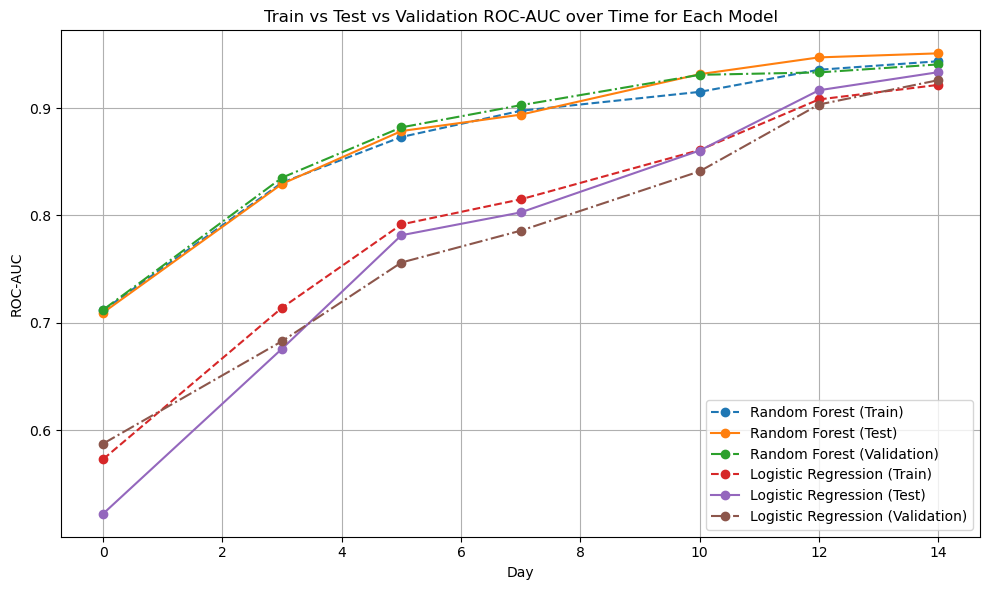

In [35]:
# Plot ROC-AUC for train, test, and validation over time for each model
plt.figure(figsize=(10, 6))

for model_name in models:
    # Plot Train ROC-AUC
    plt.plot(days[:len(auc_by_day_train[model_name])], auc_by_day_train[model_name], label=f'{model_name} (Train)', linestyle='--', marker='o')
    
    # Plot Test ROC-AUC
    plt.plot(days[:len(auc_by_day_test[model_name])], auc_by_day_test[model_name], label=f'{model_name} (Test)', linestyle='-', marker='o')

    # Plot Validation ROC-AUC
    plt.plot(days[:len(auc_by_day_val[model_name])], auc_by_day_val[model_name], label=f'{model_name} (Validation)', linestyle='-.', marker='o')

plt.xlabel('Day')
plt.ylabel('ROC-AUC')
plt.title('Train vs Test vs Validation ROC-AUC over Time for Each Model')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

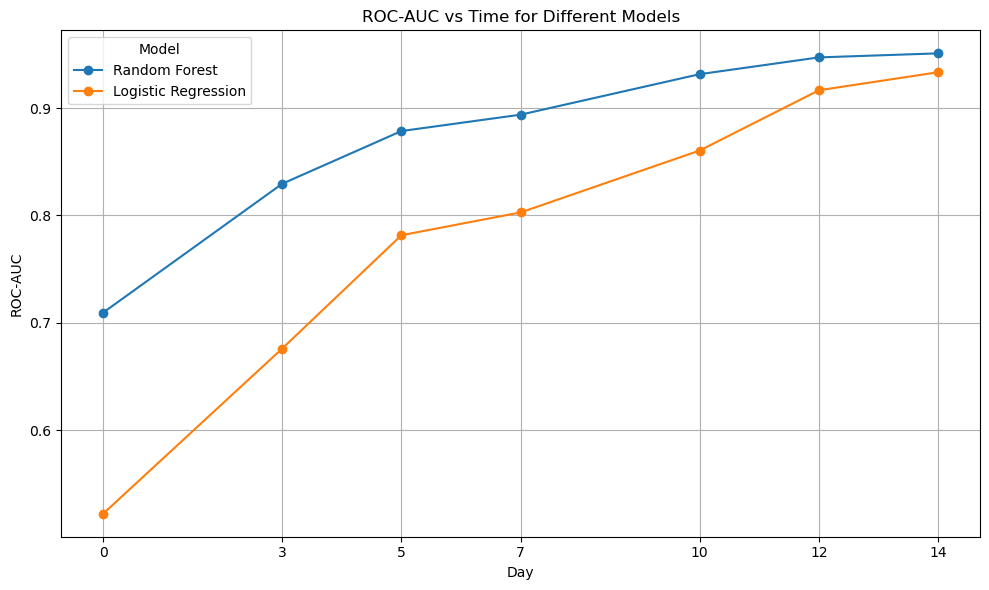

In [39]:
# Optional: Plot ROC-AUC vs time for test set
plt.figure(figsize=(10, 6))
for model_name, auc_scores in auc_by_day_test.items():
    plt.plot(days[:len(auc_scores)], auc_scores, marker='o', label=model_name)

plt.title('ROC-AUC vs Time for Different Models')
plt.xlabel('Day')
plt.ylabel('ROC-AUC')
plt.xticks(days)
plt.legend(title='Model')
plt.grid(True)
plt.tight_layout()
plt.show()

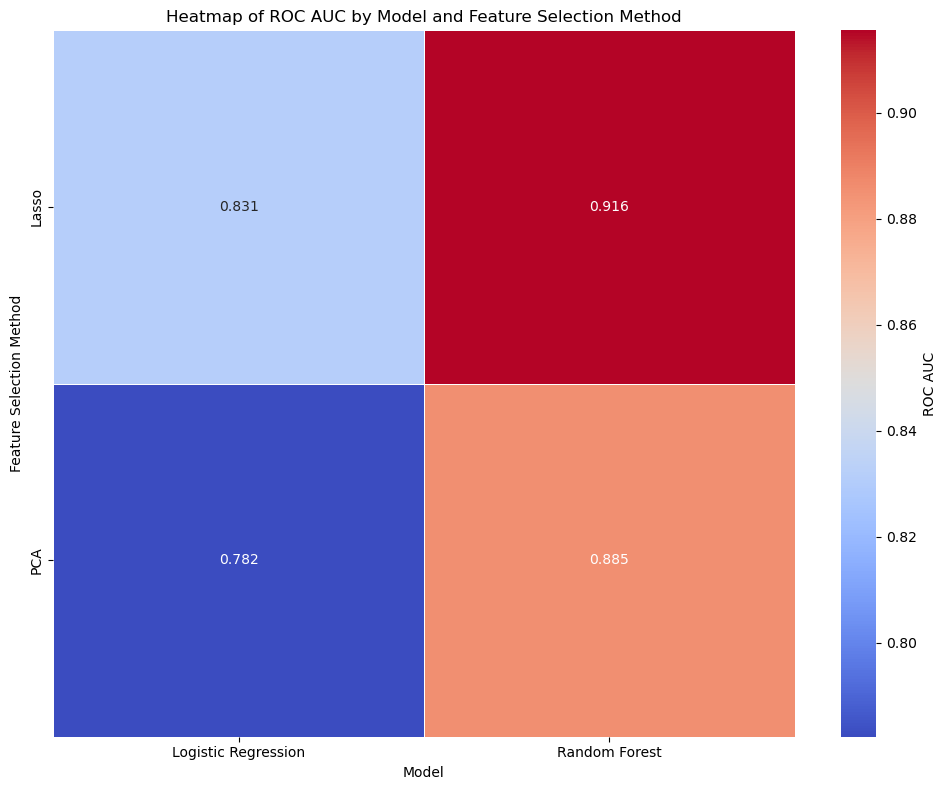

In [37]:
# Plot the heatmap of ROC AUC scores by feature selection and model
plt.figure(figsize=(10, 8))
sns.heatmap(results_pivot, annot=True, fmt=".3f", cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'ROC AUC'})
plt.title('Heatmap of ROC AUC by Model and Feature Selection Method')
plt.xlabel('Model')
plt.ylabel('Feature Selection Method')
plt.tight_layout()
plt.show()